Reinforcement Learning

References:  
[1] Hands-On Machine Learning, Aurélien Géron, 3rd edition, O'reilly

# Few notions

**Reinforcement Learning definition**:  
A software agent makes observations and takes actions within an environnment and in return it receives a rewards from the environnment. Its objective is to learn to act in a way that will maximize its expected reward over time.

**Policy**: The function the agent uses to determine its actions $\;\;\Pi : O \rightarrow A$. When this policy involves randomness we call it stochastic policy.  
            - *Grid search policy*: looking for the best settings of the parameters by exploring a grid of values.  
            - *Bruce force approch search policy*: The agents tries random values of parameters and choose the best setting.  

**Policy Gradients** is an algorithm used to update the policy function. It optimizes the parameters of a policy by following the gradients towards higher rewards. Here's one common variant of Reinforce algorithms:  
> 1) The net plays several games and at each steps compute the gradients of the rewards
> 2) Once several games have been run, compute each action's advantage 
> 3) If action has a postive action's advantage we'd like the agent to choose the action more likely meaning we'd like to apply apply the gradients whereas if the action's advantage is negative, we'd like to apply the opposite of the gradients. Each gradient vector is multiplied by the corresponding action's advantage.
> 4) Compute the mean of all resulting gradient vectors and use it to perform the gradient descent step.

**Evaluating actions**: As the reward is delayed, the problem cannot boils down to a simple supervised learning. The credit assignement problem is the difficulty to link which actions caused the good or bad reward from the environnment. To tackle this problem we consider the sum of all future rewards after that the action has been taken $\sum_{i=t}^{n} \gamma^{i-t} \times r_i$ it is used with a discount factor $\gamma$. The best way to interprete the discount factor is to find at which index $k$ $\gamma^k$ equals $0.5$.  
To evaluate the *action's advantage* we must run many episodes and normalize all actions returns. Action with positive action advantage were good whereas actions with negative ones were bad.  

**Other methods**:   
As it might exists a lot of states and actions, the policy might be really complicated therefore we might choose an algorithm that learns to estimate the expected return for each state or each action in each state and use this knowlegde to learn how to act.

# Project

### Environnement

In [177]:
import gym
import numpy as np


import matplotlib.pyplot as plt

Obs description
horizontal position: 0.02739560417830944
horizontal velocity: -0.006112155970185995
angle: 0.03585979342460632
angular rotation: 0.019736802205443382


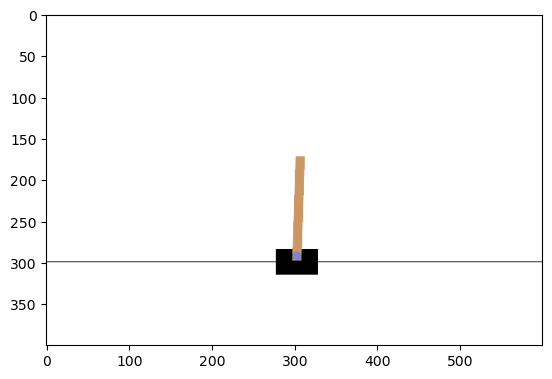

[ 0.02727336  0.18847767  0.03625453 -0.26141977]
1.0
False
False
{}


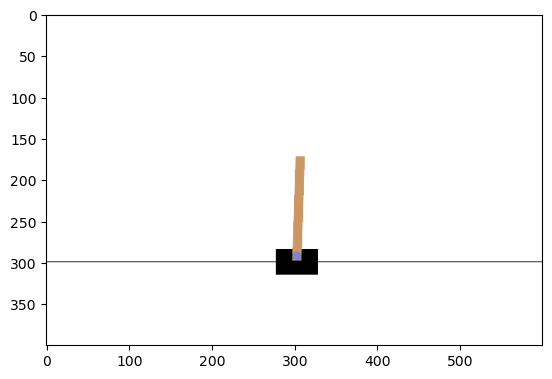

In [178]:
env = gym.make ("CartPole-v1", render_mode="rgb_array")

# Init the env
obs, info = env.reset(seed=42)
print(f"Obs description\nhorizontal position: {obs[0]}\nhorizontal velocity: {obs[1]}\nangle: {obs[2]}\nangular rotation: {obs[3]}")

# Show the state
img_init_state = env.render()
plt.imshow(img_init_state)
plt.show()

# Show available actions (left/right)
env.action_space 

# Example of action
action = 1
obs, reward, done, truncated, _ = env.step(action)

print(obs)
print(reward)
print(done)
print(truncated)
print(info)

img_state = env.render()
plt.imshow(img_state)
plt.show()

### Basic and deterministic policy 
We will try the following policy: when the pole is titled toward the right, the cart go right and when the pole is titled toward the left we go left. 
$$
\Pi : O \rightarrow A \\
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; o \rightarrow 1 \text{\;if angle > 0 and\;} 0 \text{\;else} 

In [179]:
def simple_deterministic_policy(obs):
    if obs[2] > 0:
        return 1
    else:
        return 0

In [180]:
# Test of the policy
def run_episodes(n_episodes, n_max_steps, policy):
    
    rewards = list()

    for episode in range(n_episodes):

        running_reward = 0
        obs, info = env.reset(seed=episode)

        for step in range(n_max_steps):

            action = policy(obs)
            obs, reward, done, truncated, _ = env.step(action)
            running_reward += reward

            if truncated or done:
                break 

        rewards.append(running_reward)
        env.close()

    return rewards

In [181]:
n_episodes  = 500 
n_max_steps = 200
rewards_list = run_episodes(n_episodes, n_max_steps, simple_deterministic_policy)

# Print info
print(f"Statistic on results\nMean reward: {np.mean(rewards_list)}\nMedian reward: {np.median(rewards_list)}\nStd: {np.std(rewards_list):.2f}\nMax reward: {np.max(rewards_list)}")

Statistic on results
Mean reward: 41.698
Median reward: 40.0
Std: 8.39
Max reward: 63.0


In [182]:
import imageio
import cv2 as cv
import os

In [183]:
# Check video for one episode 
def add_episode_label_on_img(frame, episode_num):

    if np.mean(frame) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    
    cv.putText(frame, f'Episode: {episode_num+1}', (frame.shape[0]//20, frame.shape[1]//18), cv.FONT_HERSHEY_SIMPLEX, 1, text_color, 2)

    return frame

def add_reward_label_on_img(frame, reward):

    if np.mean(frame) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    
    cv.putText(frame, f'REWARD: {reward}', (frame.shape[0] - frame.shape[0]//3 - 10, frame.shape[1] - frame.shape[1]//3 - 10), cv.FONT_HERSHEY_SIMPLEX, 1, text_color, 2)

    return frame


def get_episodes_frames(env, n_episodes, n_max_steps, policy):

    frames_all_episodes = []
    
    for episode in range(n_episodes):

        obs, _ = env.reset(seed=episode)
        running_reward = 0

        # Collect init image
        init_frame = env.render()
        add_episode_label_on_img(init_frame, episode_num=episode)
        frames_all_episodes.append(init_frame)

        for step in range(n_max_steps):

            action = policy(obs)
            obs, reward, done, truncated, _ = env.step(action)

            # Collect image
            frame = env.render()
            add_episode_label_on_img(frame, episode)
            frames_all_episodes.append(frame)

            running_reward += reward

            if truncated or done:

                last_frame = add_reward_label_on_img(frame, running_reward)

                for i in range(20):
                    frames_all_episodes.append(last_frame)
                    
                break

    env.close()

    return frames_all_episodes

In [184]:
env         = gym.make ("CartPole-v1", render_mode="rgb_array")
n_episodes  = 50 
n_max_steps = 200

#frames = get_episodes_frames(env, n_episodes, n_max_steps, simple_deterministic_policy)
#imageio.mimwrite(os.path.join('./videos/', 'basic_policy_agent_50_episodes.gif'), frames, fps=60)

### Neural Network policy

**We choose to define a stochastic policy.**  
As there are only two actions possible - moving to the left or moving to the right - our network will estimate the probability $p$ of choosing the action of moving to the left.   
Let X be the random variable that associates "go to the left" to $0$ and "go to the right" to $1$. In the way we created our simple regression model, X follows the Bernoulli distribution.

In [185]:
import torch
from torch import nn
from torchinfo import summary
import copy
import numpy as np

##### Basic model

Two dense layers:
- first takes as an input a tensor or size $4 \times 1$ (+ biais) and is composed of 5 hidden units
- second layer is composed of 1 neuron with sigmoid activation to obtain the probability $p$ of choosing the right

In [186]:
class SimpleRegression(nn.Module):

    def __init__(self, input_layer, n_hidden_units, n_hidden_layers):
        super().__init__()
        # don't forget to add try here
        self.n_hidden_layers = n_hidden_layers

        model = []
        for i in range(self.n_hidden_layers + 1):
            # input layer
            if i == 0:
                model += [nn.Linear(input_layer, n_hidden_units)]
                model += [nn.ReLU()]
            # hidden layers
            elif i > 0 and i < (self.n_hidden_layers):
                model += [nn.Linear(n_hidden_units, n_hidden_units)]
                model += [nn.ReLU()]
            # output_layer
            elif i == (self.n_hidden_layers):
                model += [nn.Linear(n_hidden_units, 1)]
                #model += [nn.Sigmoid()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [187]:
simple_reg = SimpleRegression(4,5,1)
summary(simple_reg, (1,4))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleRegression                         [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 5]                    25
│    └─ReLU: 2-2                         [1, 5]                    --
│    └─Linear: 2-3                       [1, 1]                    6
Total params: 31
Trainable params: 31
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

#### Training strategy

We'll implement a simple variant of Policy Gradient as given in the introduction of this notebook. We set the hyperparameters as follow:
- number of episodes before updating the policy = 10
- number of updates = 10
- number of maximum steps = 200 (limits imposed by the game)  
  
We'll test several *discount factors*.  
  
Our loss function will be the simpliest : binary cross entropy. Our optimizer will be the Adam optimizer.

In [188]:
def run_one_step(env, obs, model, loss_fn, optimizer, device):
    """
        Run one step and add the gradient in the output variables
    """
    grads = []

    # Set all grads of the model to 0
    optimizer.zero_grad()

    obs_tensor = torch.tensor(obs).unsqueeze(0).to(device)

    # Check the differenciation
    with torch.autograd.set_detect_anomaly(True):
        left_proba = model(obs_tensor)
        #print("left_proba: ", nn.Sigmoid()(left_proba))
        # Choose False with probability left_proba
        action = torch.randn(left_proba.shape, device=device) > left_proba
        #print("action: ", action)
        # if action = 0 then the probability to go right will be one
        y_target = torch.ones(left_proba.shape, device=device) - action.float()
        #print("y_target: ", y_target)
        #loss = - left_proba * y_target + (1 - left_proba) * (1 - y_target)
        loss = - loss_fn(y_target, left_proba) 
        #print("loss: ", loss)

        # Compute the gradients of each parameters
        loss.backward()

    # Collect all gradients in the model parameters
    for param in model.parameters():
        grads.append(param.grad.clone())

    #print(grads)

    obs, reward, done, truncated, info = env.step(int(action.item()))

    return obs, reward, done, truncated, info, grads

In [189]:
def run_episodes_before_policy_gradient_update(env, n_episodes_per_update, n_max_steps, policy, loss_fn, optimizer, device,
                                               generate_GIF=False):

    rewards_all_episodes = []
    grads_all_episodes   = []

    if generate_GIF:
        frames = []

    for episode in range(n_episodes_per_update):

        running_rewards = []
        running_grads   = []

        obs, _ = env.reset()

        for step in range(n_max_steps):

            obs, reward, done, truncated, info, grads = run_one_step(env, obs, policy, loss_fn, optimizer, device)

            running_rewards.append(reward)
            running_grads.append(grads)

            if generate_GIF:
                frame = env.render()
                labelled_frame = add_episode_label_on_img(frame, episode)
                frames.append(labelled_frame)

            if done or truncated:
                break

        rewards_all_episodes.append(running_rewards)
        grads_all_episodes.append(running_grads)

    if generate_GIF:
        return rewards_all_episodes, grads_all_episodes, frames
    else:
        return rewards_all_episodes, grads_all_episodes

In [190]:
def discount_rewards(rewards, discount_factor):
    """
                              N-k 
       discounted_reward[k] = sum (gamma^j x r^(j+k))
                              j=0 

        where : k is the index of the k-th reward
                r is the reward
                gamma is the discount factor
                N is the number of rewards (N = len(rewards))
    """
    discounted_rewards = np.array(rewards)

    for k in range(len(rewards) - 2, -1, -1):
        discounted_rewards[k] += discounted_rewards[k + 1] * discount_factor

    return discounted_rewards

def normalize_discounted_rewards(rewards_all_batch, discount_factor):
    """
        Compute the discount on all the batch of episodes and stock them in an array 
        then compute the normalization of it
    """
    discounted_all_batch = [discount_rewards(rewards, discount_factor) for rewards in rewards_all_batch]
    flat_rewards = np.concatenate(discounted_all_batch)
    mean_reward = flat_rewards.mean()
    std_reward  = flat_rewards.std()
    return [(discounted_rewards - mean_reward) / std_reward for discounted_rewards in discounted_all_batch]

In [191]:
# Test
print(discount_rewards(rewards=[10,0,-50], discount_factor=0.8))
print(normalize_discounted_rewards(rewards_all_batch=[[10,0,-50], [10,20]], discount_factor=0.8))

[-22 -40 -50]
[array([-0.28435071, -0.86597718, -1.18910299]), array([1.26665318, 1.0727777 ])]


#### Test

In [192]:
def save_model(model, model_file_path):
        """
            Function to save model's parameters
        """
        torch.save(copy.deepcopy(model.state_dict()), model_file_path)

def load_model(model, model_file_path):
    """
        Function to load model's parameters
    """
    model.load_state_dict(torch.load(model_file_path))
    model.eval()

def init_weights(component):
    if type(component) == nn.Linear:
        torch.nn.init.xavier_uniform_(component.weight)
        component.bias.data.fill_(0)

In [193]:
def simple_reg_training(n_iter, n_episodes_per_update, n_max_steps, discount_factor,
                        policy, loss_fn, optimizer, device,
                        policy_file_path, best_policy_file_path):
    
    if device == 'cuda':
        policy = policy.to(device)

    policy.train()
    
    best_mean_reward = 0.0

    for i in range(n_iter):

        rewards_all_batch, grads_all_batch = run_episodes_before_policy_gradient_update(env, n_episodes_per_update, n_max_steps, policy, loss_fn, optimizer, device, 
                                                                                        generate_GIF=False)

        
        mean_reward = sum([sum(rewards) for rewards in rewards_all_batch]) / n_episodes_per_update

        # Display mean reward
        print(f"\rIteration: {i + 1}/{n_iter},"
              f"mean reward: {mean_reward:.1f}")
        print([sum(rewards) for rewards in rewards_all_batch])
        
        # save best policy
        if mean_reward > best_mean_reward:
            save_model(policy, best_policy_file_path)
            best_mean_reward = mean_reward

        all_norm_rewards = normalize_discounted_rewards(rewards_all_batch, discount_factor)

        mean_grads_all_batch = []

        for param_idx, params in enumerate(policy.parameters()):

            weighted_grads = []

            for episode, norm_rewards_few_episodes in enumerate(all_norm_rewards):
                for step, norm_reward in enumerate(norm_rewards_few_episodes):

                    weighted_grads += [torch.tensor(norm_reward).item() * grads_all_batch[episode][step][param_idx]]

            mean_grads = torch.stack(weighted_grads).mean(dim=0)
            mean_grads_all_batch.append(mean_grads)

            if param_idx == -1:
                print("WEIGHTED\n",weighted_grads)
                print("MEAN\n", mean_grads)

        # Compute the gradient
        optimizer.zero_grad()
        for param, gradient in zip(policy.parameters(), mean_grads_all_batch):
            param.grad = gradient
        optimizer.step()

    # save policy
    save_model(policy, policy_file_path)


In [194]:
# Test with this policy
n_iter = 1000
n_episodes_per_update = 2
n_max_steps = 200
discount_factor = 0.95
lr_ = 0.0001

# 400, 10, 0.99, 0.0001 --> MEDIUM
# 300, 10, 0.95, 0.0001 --> BAD
# 300, 10, 0.9,  0.0001 --> MEDIUM
# 300, 10, 0.9, 0.00001 --> MEDIUM GOOD
# 200, 10, 0.85,  0.0001 --> BAD
# 200, 10, 0.95,  0.001 --> BAD

torch.manual_seed(5)

policy = SimpleRegression(4,5,1)
policy.apply(init_weights)

optim = torch.optim.NAdam(policy.parameters(), lr=lr_)
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

policy_file_path = "./saving/simple_rep_policy.pt"
best_policy_file_path = "./saving/best_policy.pt"

# simple_reg_training(n_iter, n_episodes_per_update, n_max_steps, discount_factor,
#                     policy, loss_fn, optim, device,
#                     policy_file_path, best_policy_file_path)

In [195]:
def get_episodes_frames_neural_net(env, n_episodes, n_max_steps, policy):

    frames_all_episodes = []
    
    policy.eval()

    with torch.no_grad():

        for episode in range(n_episodes):

            obs, _ = env.reset(seed=episode)
            running_reward = 0

            # Collect init image
            init_frame = env.render()
            add_episode_label_on_img(init_frame, episode_num=episode)
            frames_all_episodes.append(init_frame)

            for step in range(n_max_steps):

                obs_tensor = torch.tensor(obs).unsqueeze(0).to(device)                
                right_proba = policy(obs_tensor)
                # Choose False with probability 
                action = torch.randn(right_proba.shape).to(device) > right_proba
                action = torch.ones(right_proba.shape).to(device) - action.float()
                action = int(action.item())
                obs, reward, done, truncated, _ = env.step(action)

                # Collect image
                frame = env.render()
                add_episode_label_on_img(frame, episode)
                frames_all_episodes.append(frame)

                running_reward += reward

                if truncated or done:

                    last_frame = add_reward_label_on_img(frame, running_reward)

                    for i in range(20):
                        frames_all_episodes.append(last_frame)
                        
                    break

    env.close()

    return frames_all_episodes

In [196]:
env         = gym.make ("CartPole-v1", render_mode="rgb_array")
n_episodes  = 15
n_max_steps = 200

# load best policy
best_policy = SimpleRegression(4,5,1)
best_policy_file_path = "./saving/simple_rep_policy.pt"
load_model(best_policy, best_policy_file_path)
best_policy = best_policy.to(device)

#frame_all_episodes = get_episodes_frames_neural_net(env, n_episodes, n_max_steps, best_policy)
#imageio.mimwrite(os.path.join('./videos/', 'best_pg_agent_15_episodes.gif'), frame_all_episodes, fps=60)

### Deep Q Learning (DQN)

Bellman's equations - optimal state value $V^*$ and optimal state action value $Q^*$ - are used to know which state is optimal and which action is optimal given the agent being in a certain state. They are defined as follow: 
$$
\forall s, V^*(s) = \max_a ( \sum_{s'} T(s,a,s') R(s,a,s') + \gamma \cdot V^*(s') ) \\
\forall (s,a), Q^*(s,a) = \max_a ( \sum_{s'} T(s,a,s') R(s,a,s') + \gamma \cdot S^*(s',a))
$$
Several algorithms can be used to find the values of the optimal V-value and Q-value: 
> 1. V-value and Q-value iteration when the number of states and action is finished (and the set isn't too big) and they're all known;  
> 2. Temporal difference learning (TD learning) when partial knowledge of the MDP (high temporal complexity) (*on-policy*);  
> 3. Q-learning when partial knowledge of the MDP by randomly exploring the states and actions (high temporal complexity) (*off-policy*);  

Considering the complexity of our problem, we'll use a Deep Q-network.  
In this case, the function objective will be 
$$
    y(s,a) = r + \gamma \cdot max_{a'}  Q_{theta}(s', a')
$$
to obtain the policy where $\pi (s) = \argmax_{a} y(s,a)$. Also, we'll use an $\epsilon$-greedy policy to explore some behaviour and find some states that might not be find else.

##### DQN

In [197]:
import torch.nn as nn
import torch
from torchinfo import summary

In [198]:
class vanilla_DQN(nn.Module):

    def __init__(self, n_inputs, n_hidden_units, n_ouputs, device) -> None:
        super().__init__()

        self.device = device

        self.model = nn.Sequential(
                        nn.Linear(n_inputs, n_hidden_units),
                        nn.ELU(),
                        nn.Linear(n_hidden_units, n_hidden_units),
                        nn.ELU(),
                        nn.Linear(n_hidden_units, n_ouputs)
                    )
        
        self.model = self.model.to(self.device)

    def forward(self, x):
        return self.model(x)

In [199]:
dqn = vanilla_DQN(4, 32, 2, 'cuda:0')
summary(dqn, (1,4))

Layer (type:depth-idx)                   Output Shape              Param #
vanilla_DQN                              [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 32]                   160
│    └─ELU: 2-2                          [1, 32]                   --
│    └─Linear: 2-3                       [1, 32]                   1,056
│    └─ELU: 2-4                          [1, 32]                   --
│    └─Linear: 2-5                       [1, 2]                    66
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

##### Utils for the training

In [200]:
import numpy as np
# queue elements can be added/removed from both ends
from collections import deque 

In [201]:
def epsilon_greedy_policy(state, model, n_outputs, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        state_tens = torch.tensor(state).unsqueeze(0).to(model.device)
        Q_values = model(state_tens)[0]
        #print("Q_values", Q_values)
        return Q_values.argmax().item()
    
def sample_experience(replay_buffer, batch_size, device):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch   = [replay_buffer[idx] for idx in indices]
    res = [np.array([experience[field_idx] for experience in batch])
                for field_idx in range(6)
           ] 
    #print("res", len(res))
    return res

##### Training

In [225]:
def play_one_step(env, state, model, n_outputs, epsilon, replay_buffer):
    action = epsilon_greedy_policy(state, model, n_outputs, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

def training_step(model,  replay_buffer, 
                  batch_size, n_outputs, discount_factor, 
                  loss_fn, optimizer, 
                  device):

    experiences = sample_experience(replay_buffer, batch_size, device)
    states, actions, rewards, next_states, dones, truncateds = experiences
    #print("Reward: ", len(rewards))
    next_states_tens = torch.from_numpy(next_states).to(device)
    next_Q_values = model(next_states_tens)
    #print(next_Q_values)
    max_next_Q_values = torch.max(next_Q_values, dim=1).values
    #print(max_next_Q_values)
    runs = 1.0 - (dones | truncateds)
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values.detach().cpu().numpy()
    target_Q_values = target_Q_values.reshape(-1, 1)
    target_Q_values = torch.tensor(target_Q_values).float().to(device)
    mask = torch.nn.functional.one_hot(torch.from_numpy(actions), num_classes=n_outputs).to(device)

    optimizer.zero_grad()
    states_tens = torch.from_numpy(states).to(device)
    all_Q_values = model(states_tens)
    Q_values = torch.sum(all_Q_values * mask, axis=1).reshape(-1,1)
    #print(Q_values.shape)
    #print("Q_values", Q_values)
    #print(target_Q_values.shape)
    loss = loss_fn(target_Q_values, Q_values)
    loss.backward()
    optimizer.step()

def training(env, n_episodes, max_steps,
             model,  replay_buffer, 
             batch_size, n_outputs, discount_factor, 
             loss_fn, optimizer, 
             device):

    for episode in range(n_episodes):
        obs, info = env.reset()
        for step in range(max_steps):
            # exploration slowly decreasing
            epsilon = max(1 - episode / 500, 0.01)
            obs, reward, done, truncated, _ = play_one_step(env, obs, model, n_outputs, epsilon, replay_buffer)
            if done or truncated:
                break
        
        if episode > 50:
            training_step(model,  replay_buffer, 
                          batch_size, n_outputs, discount_factor, 
                          loss_fn, optimizer, 
                          device)


##### Test

In [226]:
env = gym.make ("CartPole-v1", render_mode="rgb_array")
n_episodes = 600
max_steps = 200
model = dqn
replay_buffer = deque(maxlen=2000)
batch_size = 32
n_outputs = 2
discount_factor = 0.01
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
device = 'cuda'

training(env, n_episodes, max_steps,
         model,  replay_buffer, 
         batch_size, n_outputs, discount_factor, 
         loss_fn, optimizer, 
         device)